In [43]:
!pip install lightning


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
!pip install natasha


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import pandas as pd
import numpy as np
from natasha import Segmenter, Doc
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch
from torch import nn

import torchmetrics
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import ModelSummary
from lightning.pytorch.tuner import Tuner
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks import Callback
import matplotlib.pyplot as plt

from navec import Navec
from slovnet.model.emb import NavecEmbedding

###**Text classification with Word Embeddings**

In [46]:
csv_file_path = 'files/new_categ.csv'
dataframe = pd.read_csv(csv_file_path)
dataframe

,id,text,subject,attachment_filename,category
0,82,Добрый вечер! \nОтсылаю материалы рецензии на ...,Повторная отправка,Рецензия Гаршиной.doc,рецензирование
1,83,Спасибо.Нечаев.,Re: Шаблон рецензии (новый),NaN,другое
2,90,"Добрый день! \nПосылаю рецензию \nС уважением,...",RE: статья Вестник САИТ Рецензия,Рецензия Толстоброва на статью А.С. Платонова....,рецензирование
3,98,"Доброе время суток, Вероника Викторовна! \nВыс...",RE: статья для рецензирования,рецензия_на_Проблема защита_пользователей.docx,рецензирование
4,92,"Добрый день! \nПосылаю рецензию \nС уважением,...",RE: рецензия на статью,Рецензия Толстоброва на статью Черненькая-Маге...,рецензирование
...,...,...,...,...,...
820,1065,Высылаю рецензию на материал А.М. Сагдатуллина...,Re: статья на рецензию,Рецензии Сагдатуллина А_М_САИТ.docx,рецензирование
821,1068,Здравствуйте ! \nМою отправлен нучную статью с...,статья,"Рис1.docx,Рис2.docx,Статья .doc",вопросы
822,1069,"Здравствуйте.\nСчитаю, что статья может быть о...",Re: Королев= ответы на замечания рецензента,"Ответ после повторного рецензирования.pdf,Реце...",рецензирование
823,1066,"Добрый день, Виктория Викторовна! \nЮристы оче...",Re: Конденсированные среды,NaN,другое


In [47]:
dataframe = dataframe.fillna('')

In [48]:
dataframe.head()

,id,text,subject,attachment_filename,category
0,82,Добрый вечер! \nОтсылаю материалы рецензии на ...,Повторная отправка,Рецензия Гаршиной.doc,рецензирование
1,83,Спасибо.Нечаев.,Re: Шаблон рецензии (новый),,другое
2,90,"Добрый день! \nПосылаю рецензию \nС уважением,...",RE: статья Вестник САИТ Рецензия,Рецензия Толстоброва на статью А.С. Платонова....,рецензирование
3,98,"Доброе время суток, Вероника Викторовна! \nВыс...",RE: статья для рецензирования,рецензия_на_Проблема защита_пользователей.docx,рецензирование
4,92,"Добрый день! \nПосылаю рецензию \nС уважением,...",RE: рецензия на статью,Рецензия Толстоброва на статью Черненькая-Маге...,рецензирование


In [49]:
dataframe['text'] = dataframe['subject'] + ' ' + dataframe['attachment_filename'] + ' ' + dataframe['text']

In [50]:
dataframe.drop(['id', 'subject','attachment_filename'], axis=1, inplace=True)

In [51]:
dataframe.head()

,text,category
0,Повторная отправка Рецензия Гаршиной.doc Добры...,рецензирование
1,Re: Шаблон рецензии (новый) Спасибо.Нечаев.,другое
2,RE: статья Вестник САИТ Рецензия Рецензия Толс...,рецензирование
3,RE: статья для рецензирования рецензия_на_Проб...,рецензирование
4,RE: рецензия на статью Рецензия Толстоброва на...,рецензирование


In [52]:
dataframe['category'].unique()

array(['рецензирование', 'другое', 'проверка статьи',
       'готово к публикации', 'подача статьи', 'доработка', 'вопросы',
       'отклонена'], dtype=object)

In [53]:
dataframe.columns

Index(['text', 'category'], dtype='object')

In [54]:
dataframe.head()

,text,category
0,Повторная отправка Рецензия Гаршиной.doc Добры...,рецензирование
1,Re: Шаблон рецензии (новый) Спасибо.Нечаев.,другое
2,RE: статья Вестник САИТ Рецензия Рецензия Толс...,рецензирование
3,RE: статья для рецензирования рецензия_на_Проб...,рецензирование
4,RE: рецензия на статью Рецензия Толстоброва на...,рецензирование


## Предобработка

In [56]:
import re
import pandas as pd
import string

In [57]:
def remove_re_header(t: str):
    t = re.sub(r'\r+', ' ', t)
    t = re.sub(r'(>+)', '', t)
    t = re.sub(r'\xa0+', ' ', t)
    t = re.sub(r'(\n\s*)+', '\n', t)
    t = re.sub(r'-+', '', t)
    # пример 1
    pattern = r'Пересылаемое сообщение((.*?)(Тема:.*?))\n'
    # пример 2
    pattern2 = r'Original Message((.*?)(Subject:.*?))\n'
    # пример 3
    pattern3 = r'(\n\d{1,2}\s(?:января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)\s\d{4}\sг\.,\s\d{1,2}:\d{2}.*?пользователь.*?\nнаписал: \n)'
    # пример 4, пример 6
    pattern4 = r'On((.*?)(wrote:.*?))\n'
    # пример 5
    pattern5 = r'(?:Понедельник|Вторник|Среда|Четверг|Пятница|Суббота|Воскресенье).*?:\s'
    # пример 7
    pattern7 = r'\n(\d{1,2}\.\d{2}\.\d{4}, \d{2}:\d{2},.*:\s)'
    t = re.sub(pattern, '', t, flags=re.DOTALL)
    t = re.sub(pattern2, '', t, flags=re.DOTALL)
    t = re.sub(pattern3, '', t)
    t = re.sub(pattern4, '', t, flags=re.DOTALL)
    t = re.sub(pattern5, '', t, flags=re.DOTALL)
    t = re.sub(pattern7, '', t, flags=re.DOTALL)
    return t

In [58]:
def remove_re_headers(texts: list[str]):
    col = []
    for tx in texts:
        new = remove_re_header(str(tx))
        col.append(new)
    return col

In [59]:
dataframe['text'] = remove_re_headers(dataframe['text'])
dataframe.head()

,text,category
0,Повторная отправка Рецензия Гаршиной.doc Добры...,рецензирование
1,Re: Шаблон рецензии (новый) Спасибо.Нечаев.,другое
2,RE: статья Вестник САИТ Рецензия Рецензия Толс...,рецензирование
3,RE: статья для рецензирования рецензия_на_Проб...,рецензирование
4,RE: рецензия на статью Рецензия Толстоброва на...,рецензирование


In [60]:
def remove_personal_sign(texts):
    col = []
    for t in texts:
        t = str(t)
        pattern_sign = r'(Отв.*?)\n'
        pattern_sign2 = r'С уважением.*?\n'
        t = re.sub(pattern_sign, '', t)
        t = re.sub(pattern_sign2, '', t)
        col.append(t)
    return col

In [61]:
dataframe['text'] = remove_personal_sign(dataframe['text'])
dataframe.head()

,text,category
0,Повторная отправка Рецензия Гаршиной.doc Добры...,рецензирование
1,Re: Шаблон рецензии (новый) Спасибо.Нечаев.,другое
2,RE: статья Вестник САИТ Рецензия Рецензия Толс...,рецензирование
3,RE: статья для рецензирования рецензия_на_Проб...,рецензирование
4,RE: рецензия на статью Рецензия Толстоброва на...,рецензирование


In [62]:
def remove_mails_urls(texts):
    column = []
    for s in texts:
        s = str(s)
        mail = r'\S+@\S+\.\S+'
        s = re.sub(mail, '', s)
        url = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        s = re.sub(url, '', s)
        column.append(s)
    return column

In [63]:
dataframe['text'] = remove_mails_urls(dataframe['text'])
dataframe.head()

,text,category
0,Повторная отправка Рецензия Гаршиной.doc Добры...,рецензирование
1,Re: Шаблон рецензии (новый) Спасибо.Нечаев.,другое
2,RE: статья Вестник САИТ Рецензия Рецензия Толс...,рецензирование
3,RE: статья для рецензирования рецензия_на_Проб...,рецензирование
4,RE: рецензия на статью Рецензия Толстоброва на...,рецензирование


In [64]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\08642\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
from nltk.corpus import stopwords
stop = stopwords.words('russian')

def clean_text(texts):
    column = []
    texts = texts.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    for s in texts:

        s = s.lower()
        s = re.sub(r'[0-9]+', '', s)
        s = re.sub(r're', '', s)
        s = re.sub(r'fwd', '', s)
        s = re.sub(r'fw', '', s)
        s = re.sub("[" + string.punctuation + "]", " ", s)
        s = re.sub(r'\s+', ' ', s)
        column.append(s)
    return column


In [66]:
dataframe['text'] = clean_text(dataframe['text'])
dataframe.head()

,text,category
0,повторная отправка рецензия гаршиной doc добры...,рецензирование
1,шаблон рецензии новый спасибо нечаев,другое
2,статья вестник саит рецензия рецензия толстоб...,рецензирование
3,статья рецензирования рецензия на проблема за...,рецензирование
4,рецензия статью рецензия толстоброва статью ч...,рецензирование


In [67]:
dataframe.to_csv('files/7_clean_categorized.csv', index=False)

In [34]:
dataframe.loc[:, "category"] = dataframe.loc[:, "category"].astype('category').cat.codes

In [71]:
X_text = dataframe.iloc[:, 0].values
y_targets = dataframe.iloc[:, 1].values

In [35]:
dataframe['category'].unique()

array([7, 3, 6, 1, 5, 2, 0, 4], dtype=object)

In [36]:
path = '../navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [37]:
# Нахождение максимальной длины текста (в словах)
def maxTextLen(X_text, navec):
  segmenter = Segmenter()
  text_lens = []
  for text in X_text:
    doc = Doc(text)
    doc.segment(segmenter)
    text_tokens = [token.text for token in doc.tokens if token.text in navec]
    text_lens.append(len(text_tokens))
  max_text_len = max(text_lens)
  return max_text_len

# Преобразование текста в тензор
def textToTensorDataset(X_data, y_data, max_text_len, navec):
  segmenter = Segmenter()
  num_texts = len(X_data)
  texts_tensor = torch.zeros(num_texts, max_text_len + 2).long()
  targets_tensor = torch.tensor(y_data).long()

  for text_i, text in enumerate(X_text):
    doc = Doc(text)
    doc.segment(segmenter)
    text_tokens = [token.text for token in doc.tokens if token.text in navec]
    for token_i, token in enumerate(text_tokens):
        texts_tensor[text_i, token_i + 1] = navec.vocab[token]
  return TensorDataset(texts_tensor, targets_tensor)

In [38]:
max_text_len = maxTextLen(X_text, navec)
y_data = np.array([int(label) for label in y_targets])
train_dataset = textToTensorDataset(X_text, y_data, max_text_len, navec)

In [40]:
train_dataset.tensors[:5]

(tensor([[     0, 279677,   3471,  ...,      0,      0,      0],
         [     0, 376465, 250626,  ...,      0,      0,      0],
         [     0, 418784, 225007,  ...,      0,      0,      0],
         ...,
         [     0, 275608, 225007,  ...,      0,      0,      0],
         [     0, 416807, 105285,  ...,      0,      0,      0],
         [     0, 444216, 318241,  ...,      0,      0,      0]]),
 tensor([7, 3, 7, 7, 7, 6, 6, 1, 5, 5, 2, 0, 4, 2, 3, 5, 0, 5, 5, 5, 0, 0, 5, 5,
         3, 3, 3, 3, 5, 0, 5, 4, 0, 5, 5, 3, 3, 5, 0, 5, 0, 0, 0, 0, 3, 3, 0, 2,
         3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 3,
         0, 5, 5, 3, 5, 1, 0, 0, 0, 5, 5, 5, 5, 0, 0, 5, 5, 0, 5, 0, 5, 0, 0, 0,
         5, 0, 5, 0, 5, 5, 1, 3, 3, 3, 6, 6, 1, 6, 6, 4, 2, 2, 2, 6, 2, 2, 2, 2,
         6, 0, 5, 5, 2, 0, 0, 7, 7, 7, 7, 7, 7, 3, 3, 3, 6, 5, 5, 3, 7, 7, 7, 0,
         0, 5, 5, 0, 5, 3, 0, 7, 6, 5, 5, 0, 2, 0, 2, 0, 5, 0, 0, 0, 7, 2, 0, 0,
         5, 5, 0, 5, 5, 5, 

In [33]:
# Сверточный слой с функцией активации LeakyRelu
class CustomConv1D(nn.Module):
  def __init__(self,
               in_channels:int,
               out_channels:int,
               kernel_size:int,
               dilation:int):
    super().__init__()
    self.conv1d = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation)
    self.activation = nn.LeakyReLU(0.2);

  def forward(self, x):
    x = self.conv1d(x)
    x = self.activation(x)
    return x

In [34]:
# Преобразование каждого токена (слова) в вектор
# с помощью нескольких сверточных слоев и пулинга
class TokenCNN(nn.Module):
  def __init__(self,
               in_embed_size:int,
               context_embed_size:int):
    super().__init__()
    self.conv_1_1 = CustomConv1D(in_channels=in_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_1_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_1 = nn.MaxPool1d(kernel_size=3, stride=3)

    self.conv_2_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_2_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_2 = nn.MaxPool1d(kernel_size=3, stride=3)

    self.conv_3_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_3_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_3 = nn.MaxPool1d(kernel_size=3, stride=3)

    self.conv_4_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_4_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_4 = nn.MaxPool1d(kernel_size=3, stride=3)

  def forward(self, x):
    x = self.conv_1_1(x)
    x = x + self.conv_1_2(x)
    x = self.pooling_1(x)

    x = self.conv_2_1(x)
    x = x + self.conv_2_2(x)
    x = self.pooling_2(x)

    x = self.conv_3_1(x)
    x = x + self.conv_3_2(x)
    x = self.pooling_3(x)

    x = self.conv_4_1(x)
    x = x + self.conv_4_2(x)
    x = self.pooling_4(x)
    return x

In [35]:
# Завершающий линейный слой с дропаутом
class ClassificationHead(nn.Module):
  def __init__(self,
               in_features:int,
               out_features:int,
               dropout:float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, x):
    x = self.dropout(x)
    x = self.classifier(x)
    return x

In [36]:
# Реализация сети
class Network(nn.Module):
    def __init__(self,
                 num_classes,
                 max_text_len,
                 token_embedding_size=256,
                 classifier_dropout=0.5):
        super().__init__()
        self.embeddings = NavecEmbedding(navec)
        self.token_cnn = TokenCNN(in_embed_size=300, context_embed_size=token_embedding_size)
        self.global_pooling_context = nn.AdaptiveMaxPool1d(1)
        self.classification_head = ClassificationHead(in_features=token_embedding_size, out_features=num_classes, dropout=classifier_dropout)

    def forward(self, tokens):
        batch_size, max_text_len = tokens.shape            # BatchSize x MaxTextLen

        word_embeddings = self.embeddings(tokens)          # BatchSize x MaxTokenLen x EmbSize
        word_embeddings = word_embeddings.permute(0, 2, 1) # BatchSize x EmbSize x MaxTextLen

        context_features = self.token_cnn(word_embeddings)                         # BatchSize x EmbSize x MaxTextLen
        text_features = self.global_pooling_context(context_features).squeeze(-1)  # BatchSize x EmbSize
        logits = self.classification_head(text_features)                           # BatchSize x num_classes
        return logits

In [37]:
class DataModule(pl.LightningDataModule):
  def __init__(self,
               tensor_dataset,
               batch_size):
    super().__init__()
    self.tensor_dataset = tensor_dataset
    self.batch_size = batch_size
    self.prepare_data()

  def setup(self, stage=None):
    train_size = int(0.8 * len(self.tensor_dataset))
    val_size = len(self.tensor_dataset) - train_size
    self.train_data, self.val_data = random_split(self.tensor_dataset, [train_size, val_size])
    return self.train_data, self.val_data

  def train_dataloader(self):
    return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=2)

  def val_dataloader(self):
    return DataLoader(self.val_data, batch_size=self.batch_size, shuffle = False, num_workers=2)

In [38]:
# Создание модели
class ModelCompilation(pl.LightningModule):
    def __init__(self,
                 model:torch.nn.Module,
                 metrics:dict,
                 loss_function,
                 optimizer:torch.optim,
                 learning_rate:float):
        super().__init__()
        self.model = model
        self.metrics = metrics
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.save_hyperparameters(logger=False)

    def forward(self, x):
        pred = self.model.forward(x)
        return pred

    def configure_optimizers(self):
        train_optimizer = self.optimizer(self.parameters(), lr=self.learning_rate, weight_decay=0.05, betas = (0.9, 0.98), eps = 1.0e-9)
        train_scheduler = {
            "scheduler": ReduceLROnPlateau(optimizer=train_optimizer, mode="min", factor=0.1, patience=1, min_lr=5e-6),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss",
        }
        return [train_optimizer], [train_scheduler]

    def training_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'val')
        return loss

    def test_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'test')
        return loss

    def common_step(self, batch, batch_idx, stage):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_function(pred, y)
        if (stage == 'test') or (stage == 'val'):
            on_step = False
        else:
            on_step = True

        [self.log(stage + '_' + metric_name, metric(pred, y).to(device), on_step=on_step, on_epoch=True, prog_bar=True, logger=True) for metric_name, metric in self.metrics.items()]
        self.log(stage + '_' + 'loss', loss, on_step=on_step, on_epoch=True, prog_bar=True, logger=True)
        return loss, pred, y

In [39]:
class History(Callback):
    def __init__(self):
        self.history = {'val_loss': np.array([]), 'val_accuracy': np.array([]), 'train_loss_epoch' : np.array([]), 'train_accuracy_epoch' : np.array([])}

    def on_train_epoch_end(self, trainer, module):
        logs = trainer.logged_metrics
        self.history['train_loss_epoch'] = np.append(self.history['train_loss_epoch'], logs['train_loss_epoch'].cpu())
        self.history['val_loss'] = np.append(self.history['val_loss'], logs['val_loss'].cpu())
        self.history['train_accuracy_epoch'] = np.append(self.history['train_accuracy_epoch'], logs['train_accuracy_epoch'].cpu())
        self.history['val_accuracy'] = np.append(self.history['val_accuracy'], logs['val_accuracy'].cpu())

In [40]:
# Обучение модели
def fit(iteration):
  num_classes = 8
  task = 'multiclass'
  network = Network(num_classes=num_classes,
                    max_text_len=max_text_len,
                    token_embedding_size=256,
                    classifier_dropout=0.5
                    )

  metrics = {'accuracy': torchmetrics.Accuracy(task=task, num_classes=num_classes).to(device)}
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW
  learning_rate = 0.0005

  earlystopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
  checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename='model-{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}')
  history_callback = History()

  model = ModelCompilation(network, metrics, loss_function, optimizer, learning_rate)
  trainer = pl.Trainer(callbacks=[earlystopping_callback, history_callback, checkpoint_callback], precision='32', accelerator=device, devices=1, max_epochs=50)

  trainer.fit(model, datamodule=data_module)
  print("Best model score for iteration " + str(iteration) + " : " + str(checkpoint_callback.best_model_score))
  return checkpoint_callback, history_callback

In [41]:
# Обучение моделей заданное количество раз и выбор лучшей модели
device = 'cpu'
trials = 1
best_score = 100
best_model_path = ''
data_module = DataModule(tensor_dataset=train_dataset, batch_size=8)
for i in range(trials):
  checkpoint, history = fit(i)
  if(checkpoint.best_model_score < best_score):
    best_score = checkpoint.best_model_score
    best_model_path = checkpoint.best_model_path
    best_history = history

print("Best model score for " + str(trials) + " trials: " + str(best_score))
print("Best model path: " + best_model_path)

F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\slovnet\model\emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  torch.from_numpy(navec.pq.indexes),
F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best model score for iteration 0 : tensor(1.3492)
Best model score for 1 trials: tensor(1.3492)
Best model path: F:\Projects\Python\MailManagementApp\jupiter\lightning_logs\version_0\checkpoints\model-epoch=06-val_loss=1.35-val_accuracy=0.54.ckpt


In [42]:
# Вывод графиков
def plot_train_metrics(history_callback):
  plt.figure()
  plt.plot(list(range(len(history_callback.history['train_loss_epoch']))), history_callback.history['train_loss_epoch'])
  plt.plot(list(range(len(history_callback.history['val_loss']))), history_callback.history['val_loss'])
  plt.legend(['train_loss', 'val_loss'])

  plt.figure()
  plt.plot(list(range(len(history_callback.history['train_accuracy_epoch']))), history_callback.history['train_accuracy_epoch'])
  plt.plot(list(range(len(history_callback.history['val_accuracy']))), history_callback.history['val_accuracy'])
  plt.legend(['train_accuracy', 'val_accuracy'])
  plt.show()

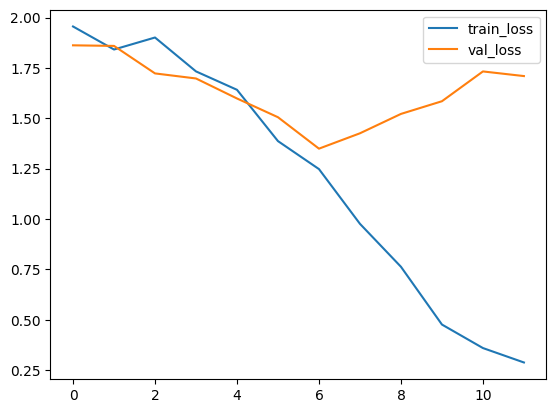

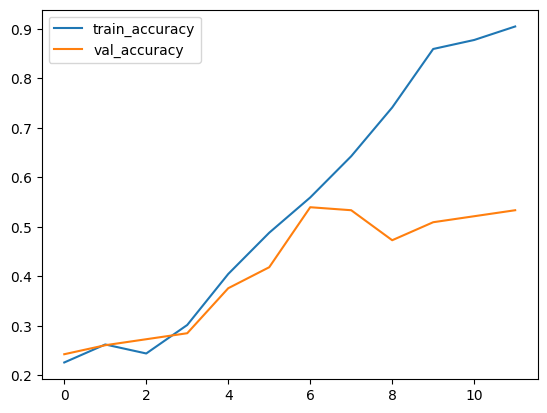

In [43]:
plot_train_metrics(best_history)

In [44]:
# Загрузка предобученной модели
def load_pretrained_model(checkpoint_path):
  num_classes = 8
  task = 'multiclass'
  network = Network(num_classes=num_classes,
                    max_text_len=max_text_len,
                    token_embedding_size=256,
                    classifier_dropout=0.5
                    )

  metrics = {'accuracy': torchmetrics.Accuracy(task=task, num_classes=num_classes).to(device)}
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW
  learning_rate = 0.0005

  model = ModelCompilation(network, metrics, loss_function, optimizer, learning_rate)
  model = ModelCompilation.load_from_checkpoint(checkpoint_path)
  return model

In [45]:
# Предсказание категории
def predictCategory(text, model, navec, max_text_len):
  texts_tensor = torch.zeros(1, max_text_len + 2).long()
  text = text.lower()
  segmenter = Segmenter()
  doc = Doc(text)
  doc.segment(segmenter)
  text_tokens = [token.text for token in doc.tokens if token.text in navec]
  for token_i, token in enumerate(text_tokens):
      texts_tensor[0][token_i + 1] = navec.vocab[token]

  model.eval()
  logits = model.forward(texts_tensor)
  proba = torch.nn.functional.softmax(logits.data, dim=1)
  return proba

In [47]:

model = load_pretrained_model(best_model_path)

F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_function'])`.


In [55]:
text = '''Тема: Статья Сандлер И.Л. Комплект документов в журнал "" Вестник ВГУ.
Серия: Системный анализ и информационные технологии "" Статья на публикацию
Добрый день уважаемая редакция!!!
В приложении архив к котором содержится четыре файла: опись, статья и  6
рисунков.
С уважением,
Илья Сандлер'''

In [56]:
prob = predictCategory(text, model, navec, max_text_len)

In [57]:
categories = ["вопросы", "готово к публикации",
              "доработка", "другое", "отклонена",
              "подача статьи", "проверка статьи", "рецензирование"]
result = {}
for i in range(len(categories)):
  category = categories[i]
  result[category] = prob[0][i]
  result_sorted = sorted(result.items(), key=lambda x: x[1], reverse=True)

res = ''
for s, p in result_sorted:
  res = res + f'{s} : {p:.5f}\n'

print(res)

подача статьи : 0.55875
вопросы : 0.23802
доработка : 0.13738
рецензирование : 0.03920
другое : 0.01589
проверка статьи : 0.00593
отклонена : 0.00403
готово к публикации : 0.00080


## Наивный Байес

In [17]:
### Загружаем библиотеки и данные
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set() # use seaborn plotting style
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('files/7_clean_categorized.csv')
data

,text,category
0,повторная отправка рецензия гаршиной doc добры...,рецензирование
1,шаблон рецензии новый спасибо нечаев,другое
2,статья вестник саит рецензия рецензия толстоб...,рецензирование
3,статья рецензирования рецензия на проблема за...,рецензирование
4,рецензия статью рецензия толстоброва статью ч...,рецензирование
...,...,...
820,статья рецензию рецензии сагдатуллина а м саи...,рецензирование
821,статья рис docx рис docx статья doc здравствуй...,вопросы
822,королев ответы замечания рецензента считаю ст...,рецензирование
823,конденсированные среды добрый день виктория в...,другое


In [3]:
d = data['category'].unique()

In [4]:
X = data.iloc[:, 0].values
y = data.iloc[:, 1].values

In [5]:
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [6]:
vectorizer.get_feature_names_out()

array(['ab', 'abbyy', 'about', ..., 'ясен', 'ясно', 'яшина'], dtype=object)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [11]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [12]:
predictions = nb_classifier.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, predictions)
print("Точность модели: {:.2f}".format(accuracy))

Точность модели: 0.64


In [14]:
input_text = "здравствуйте редакция журнала «вестник вгу» прошу разместить статью в вашем журнале с уважением алдабаева "

# Преобразование входного текста в матрицу частот слов с использованием того же объекта vectorizer
input_text_vectorized = vectorizer.transform([input_text])

# Предсказание категории для вводного текста
predicted_category = nb_classifier.predict(input_text_vectorized)

print("Предсказанная категория:", predicted_category[0])

Предсказанная категория: вопросы


In [23]:
nb_classifier.classes_

array(['вопросы', 'готово к публикации', 'доработка', 'другое',
       'отклонена', 'подача статьи', 'проверка статьи', 'рецензирование'],
      dtype='<U19')

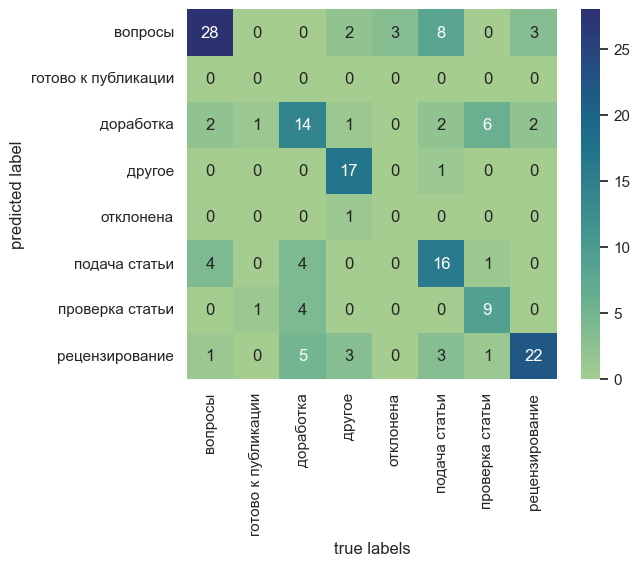

Accuracy: 0.6424242424242425


In [14]:
class_labels = nb_classifier.classes_
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=np.unique(y),yticklabels=np.unique(y), cmap="crest")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [21]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

TF-IDF

In [22]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Точность модели: {:.2f}".format(accuracy))

Точность модели: 0.68


## KNN

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [24]:
label=le.fit_transform(y)

In [25]:
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,label,test_size=0.3)

In [43]:
from sklearn.neighbors import KNeighborsClassifier
# Applying k = 3, default Minkowski distance metrics
model = KNeighborsClassifier(n_neighbors=3)
# Training the classifier
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [44]:
y_pred = model.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print("Точность модели: {:.2f}".format(accuracy))

Точность модели: 0.50
